In [12]:
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from astropy.io import ascii
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
#from astropy.cosmology import Planck18 as cosmo
import pandas as pd
import pprint
import sys
import operator
from scipy import optimize
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=71, Om0=0.27)
import seaborn as sns
from scipy.spatial.distance import cdist, euclidean
from lmfit.models import LinearModel
from lmfit import minimize, Parameters
import cmastro
import statistics as stats
plt.rcParams['figure.dpi'] = 400
plt.rcParams['figure.figsize'] = [12,10]

In [13]:
col_list = ['objname','f','f_f125w','z','UV','VJ','mag_f125w','mag_f160w','re','dre','re_f125w','dre_f125w','FAST_lmass','logstellar_mass_median','logstellar_mass_errup','logstellar_mass_errdown','sfr_100myr_median','sfr_100myr_errup','sfr_100myr_errdown','logssfr_100myr_median','logssfr_100myr_errup','logssfr_100myr_errdown']

file = ascii.read("prospector_UVJ_galfit_FAST_ERRCORR.csv", format='csv')
data = pd.read_csv('prospector_UVJ_galfit_FAST_ERRCORR.csv', index_col=0, usecols=col_list)

data.rename(columns={'f':'Flag_f160w', 'f_f125w':'Flag_f125w', 're':'R_f160w', 'dre':'dR_f160w', 're_f125w':'R_f125w', 'dre_f125w':'dR_f125w', 'logstellar_mass_median':'lmass', 'logstellar_mass_errup':'lmass_high', 'logstellar_mass_errdown':'lmass_low', 'logssfr_100myr_median':'lssfr', 'logssfr_100myr_errup':'lssfr_high', 'logssfr_100myr_errdown':'lssfr_low'}, inplace=True)

def calc_arcrad_5000(row):
    if row['z'] <= 1.5:
        return row['R_f125w']*((1+row['z'])/(1+1.5))**(-0.35+0.12*row['z']-0.25*(row['lmass']/10))
    else:
        return row['R_f160w']*((1+row['z'])/(1+1.5))**(-0.35+0.12*row['z']-0.25*(row['lmass']/10))

def calc_arcrad_5000_err(row):
    if row['z'] <= 1.5:
        return row['dR_f125w']*((1+row['z'])/(1+1.5))**(-0.35+0.12*row['z']-0.25*(row['lmass']/10))
    else:
        return row['dR_f160w']*((1+row['z'])/(1+1.5))**(-0.35+0.12*row['z']-0.25*(row['lmass']/10))

def calc_flags(row):
    if row['z'] <= 1.5:
        return row['Flag_f125w']
    else:
        return row['Flag_f160w']

    
data['lmass_errup'] = data['lmass_high']-data['lmass']
data['lmass_errdown'] = data['lmass']-data['lmass_low']
data['lssfr_errup'] = data['lssfr_high']-data['lssfr']
data['lssfr_errdown'] = data['lssfr']-data['lssfr_low']
data['arcrad_5000'] = data.apply(calc_arcrad_5000, axis=1)
data['arcrad_5000_err'] = data.apply(calc_arcrad_5000_err, axis=1)
data['flags'] = data.apply(calc_flags, axis=1)
data['lR_eff'] = np.log10(data['arcrad_5000']*(cosmo.kpc_proper_per_arcmin(data['z'].to_numpy())/60).value)
data['lR_eff_err'] = 0.434*(data['arcrad_5000_err']/data['arcrad_5000'])
data.loc[(data['UV']>1.3)&(data['VJ']<1.6)&(data['UV']>(0.88*data['VJ']+0.69)),'type'] = 'Quiescent'
data.loc[(data['UV']<1.3)|(data['VJ']>1.6)|(data['UV']<(0.88*data['VJ']+0.69)),'type'] = 'Starforming'
cleandata = data[(data['flags'] <= 1.0)]


print(data)

           Flag_f160w  Flag_f125w       z        UV        VJ   R_f160w   
objname                                                                   
AEGIS_13          0.0         1.0  1.3049  1.651843  1.903840  0.388926  \
AEGIS_17          0.0         1.0  1.7499  1.475649  1.328187  0.233094   
AEGIS_19          0.0         0.0  1.0761  0.680207  0.711274  0.316938   
AEGIS_22          0.0         0.0  1.6570  0.835242  1.123700  0.094710   
AEGIS_23          0.0         2.0  0.9595  0.650225  0.542705  0.114444   
...               ...         ...     ...       ...       ...       ...   
UDS_44077         1.0         0.0  1.1105  0.727672  0.592051  0.245802   
UDS_44079         0.0         2.0  1.1986  0.381100  0.538880  0.075528   
UDS_44085         0.0         1.0  1.0982  0.555377  0.506776  0.271944   
UDS_44088         2.0         0.0  1.5954  0.493928  0.254129  0.509202   
UDS_44090         0.0         0.0  1.4365  0.674018  0.604624  0.101502   

           dR_f160w   R_

/Users/leo/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
starforming_criteria = (cleandata['UV']<1.3)|(cleandata['VJ']>1.6)|(cleandata['UV']<(0.88*cleandata['VJ']+0.69))
quiescent_criteria = (cleandata['UV']>1.3)&(cleandata['VJ']<1.6)&(cleandata['UV']>(0.88*cleandata['VJ']+0.69))

zbins = [(cleandata['z']>=0.5) & (cleandata['z']<1.0), (cleandata['z']>=1.0) & (cleandata['z']<1.5), (cleandata['z']>=1.5) & (cleandata['z']<2.0), (cleandata['z']>=2)]
completeness50_q = [(cleandata['lmass']>9.2), (cleandata['lmass']>9.67), (cleandata['lmass']>9.9), (cleandata['lmass']>10.33)]
completeness50_sf = [(cleandata['lmass']>9.0), (cleandata['lmass']>9.29), (cleandata['lmass']>9.5), (cleandata['lmass']>9.63)]
completeness80_q = [(cleandata['lmass']>9.39), (cleandata['lmass']>9.83), (cleandata['lmass']>10.12), (cleandata['lmass']>10.67)]
completeness80_sf = [(cleandata['lmass']>9.22), (cleandata['lmass']>9.38), (cleandata['lmass']>9.82), (cleandata['lmass']>10.09)]

quiescent = []
quiescent_50 = []
quiescent_80 = []
starforming = []
starforming_50 = []
starforming_80 = []
fullsample = []



for z in range(4):
    quiescent.append(cleandata[(quiescent_criteria) & zbins[z]])
    quiescent_50.append(cleandata[(quiescent_criteria) & zbins[z] & completeness50_q[z]])
    quiescent_80.append(cleandata[(quiescent_criteria) & zbins[z] & completeness80_q[z]])
    starforming.append(cleandata[(starforming_criteria) & zbins[z]])
    starforming_50.append(cleandata[(starforming_criteria) & zbins[z] & completeness50_sf[z]])
    starforming_80.append(cleandata[(starforming_criteria) & zbins[z] & completeness80_sf[z]])
    fullsample.append(pd.concat([starforming[z],quiescent[z]]))

print(fullsample[0])

           Flag_f160w  Flag_f125w       z        UV        VJ    R_f160w   
objname                                                                    
AEGIS_27          2.0         0.0  0.6806  0.732008  0.799708   0.223662  \
AEGIS_28          0.0         0.0  0.7626  0.787097  0.647621   0.267072   
AEGIS_55          0.0         0.0  0.6970  0.839251  0.578775   0.412968   
AEGIS_83          0.0         0.0  0.7250  0.774377  0.690601   0.343890   
AEGIS_91          0.0         0.0  0.9172  0.656156  0.290892   0.307770   
...               ...         ...     ...       ...       ...        ...   
UDS_42262         0.0         0.0  0.7453  1.461182  0.813741   0.259524   
UDS_43257         1.0         0.0  0.8803  3.175630  0.096443   0.117936   
UDS_43679         0.0         0.0  0.7647  2.318405  0.479730  16.205600   
UDS_43846         0.0         0.0  0.7132  3.498815  1.295505   0.518052   
UDS_44055         2.0         1.0  0.9790  1.473861  0.416061   0.018000   

           

/var/folders/cf/h_nh_x353h98db_r9nwq4sqm0000gn/T/ipykernel_11067/3937592137.py:4: RuntimeWarning: invalid value encountered in scalar subtract
  A2=A1*mpstar**(alpha1-alpha2)
/var/folders/cf/h_nh_x353h98db_r9nwq4sqm0000gn/T/ipykernel_11067/3937592137.py:6: RuntimeWarning: invalid value encountered in multiply
  out[lmass<=mp]=A1*mstar[lmass<=mp]**alpha1


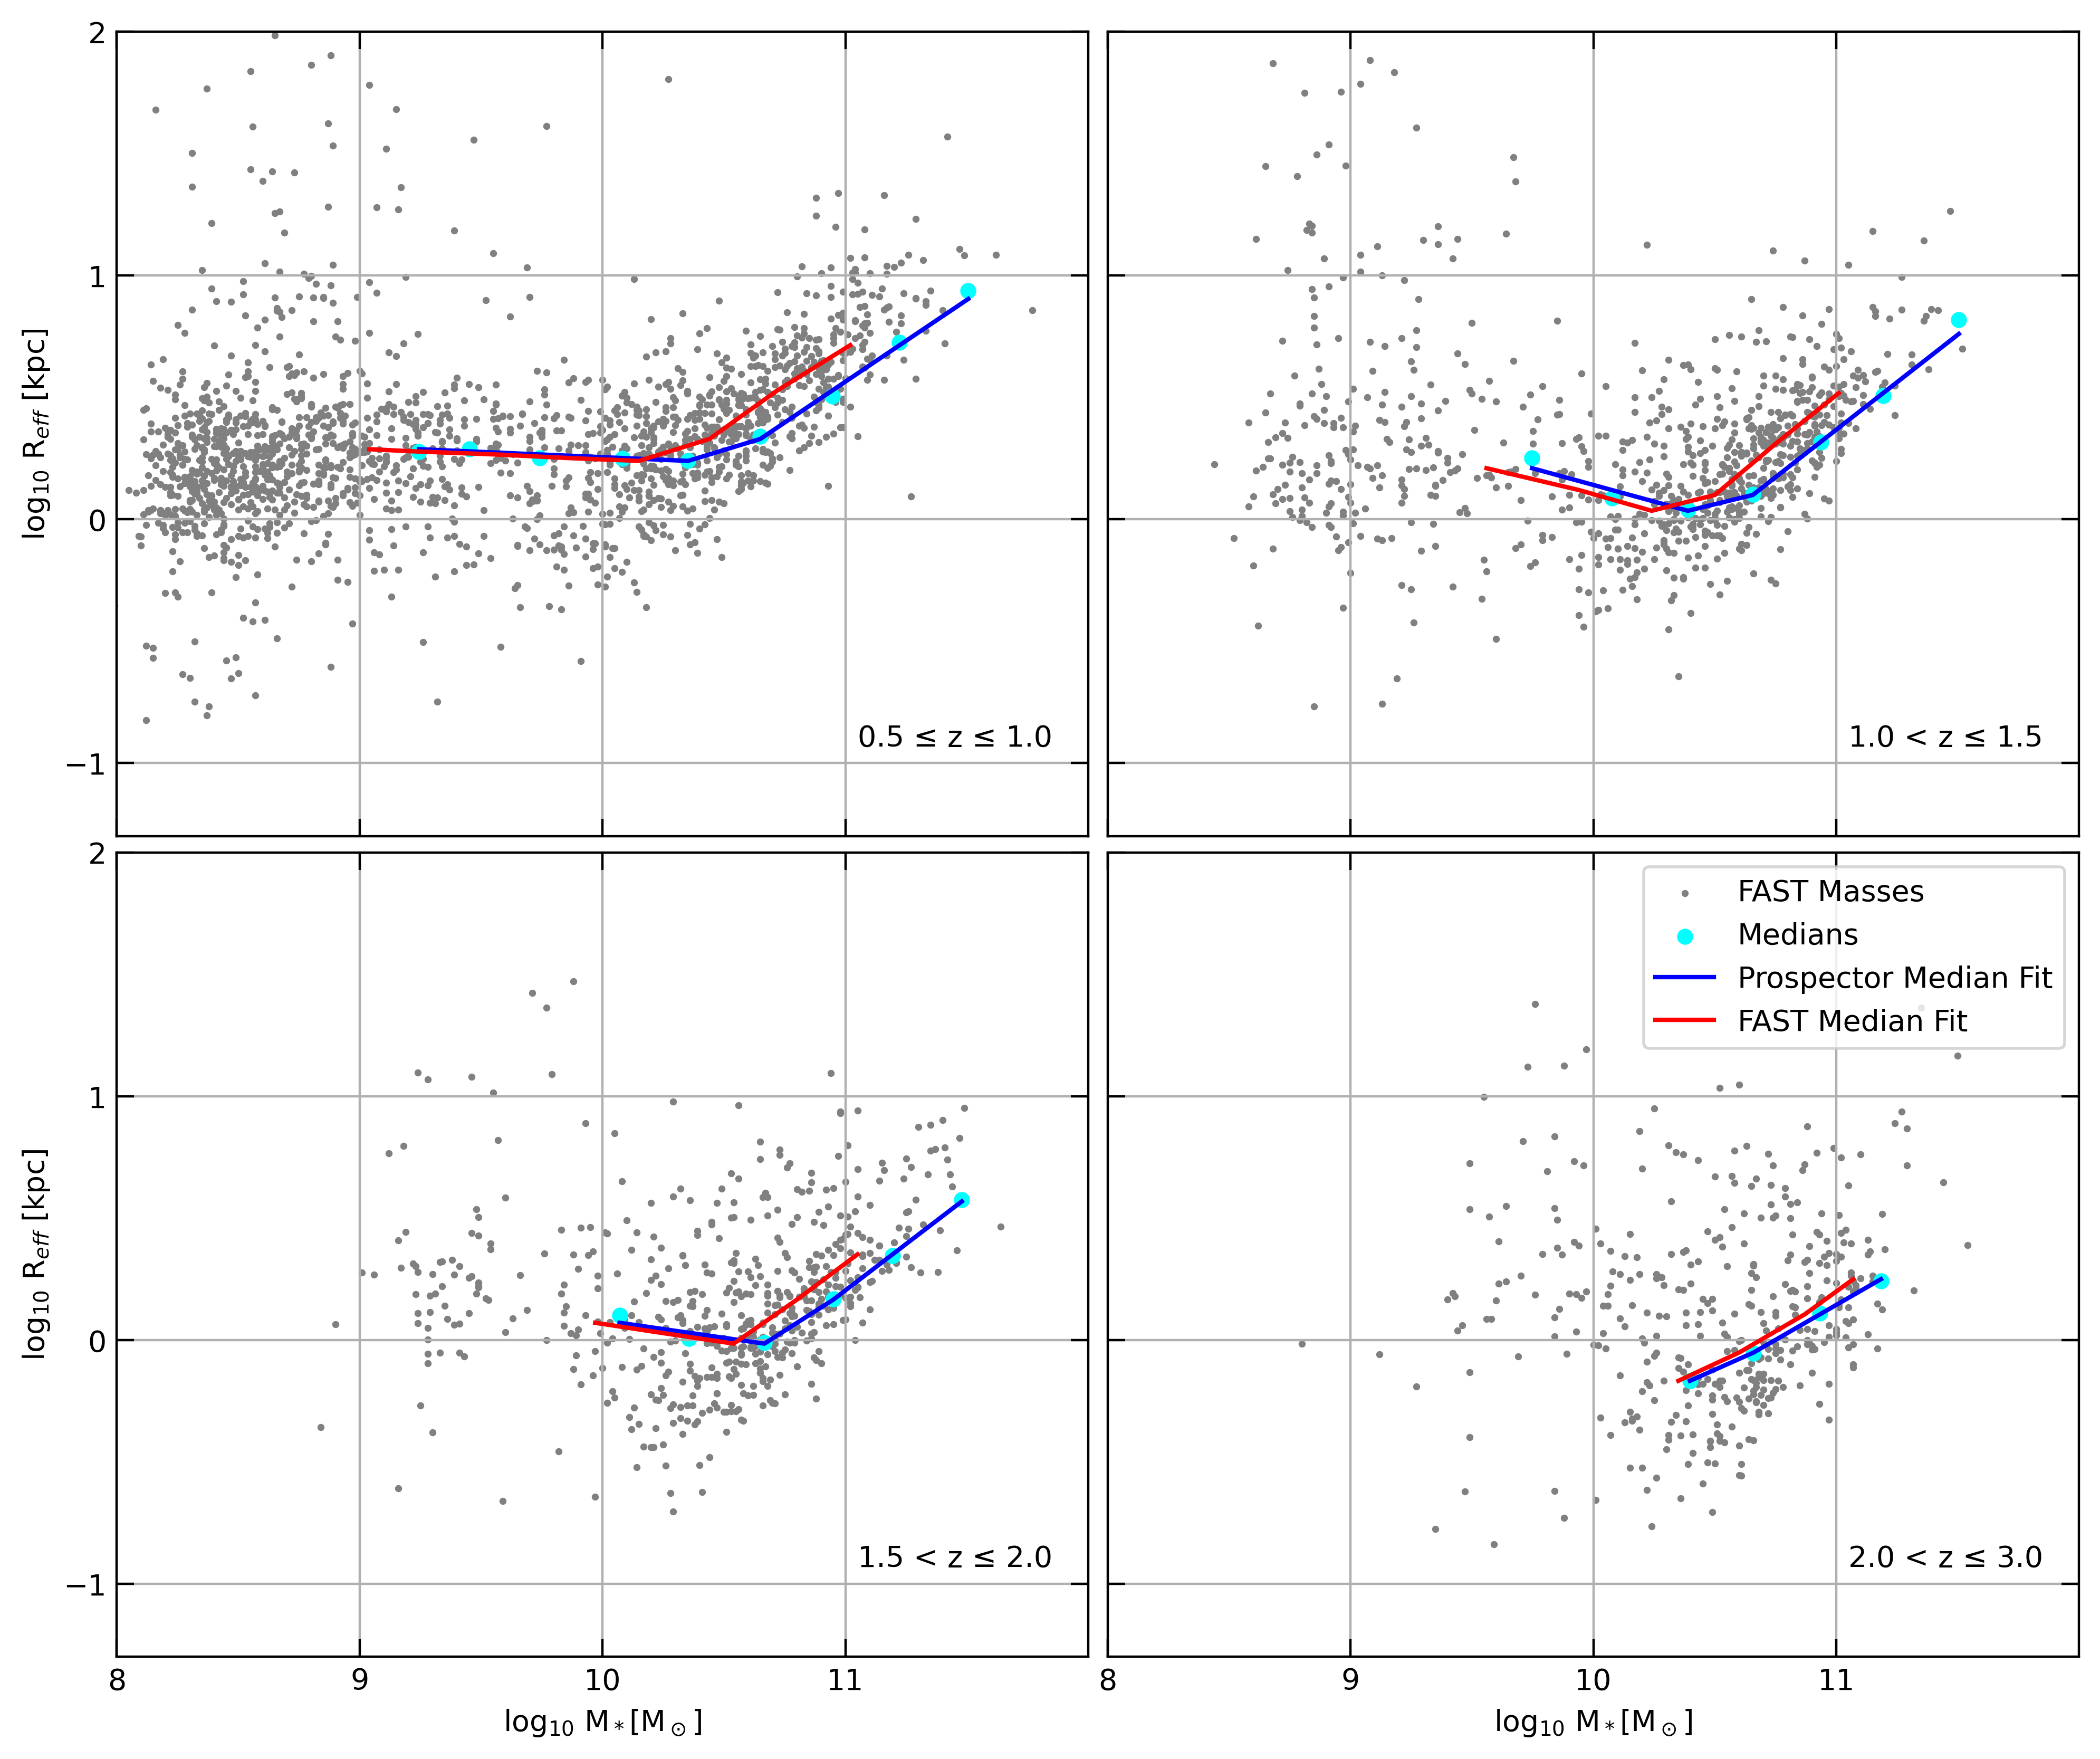

In [20]:
def broken_power_law(lmass,A1,alpha1,alpha2,mp):
    mstar=(10**lmass)/5e10
    mpstar=(10**mp)/5e10
    A2=A1*mpstar**(alpha1-alpha2)
    out=np.zeros_like(lmass)
    out[lmass<=mp]=A1*mstar[lmass<=mp]**alpha1
    out[lmass>mp]=A2*mstar[lmass>mp]**alpha2
    return np.log10(out)
    
def broken_quiescent_fit(xvals, yvals, error):   #curve fit calculation with upper fit and lower fit and comparison line
    broken_fit_q.append(curve_fit(f=broken_power_law, xdata=xvals, ydata=yvals, sigma=error, p0=x0_broken, bounds=bounds_broken))
    broken_highfit_q.append(broken_fit_q[z][0]+np.sqrt(np.diag(broken_fit_q[z][1])))
    broken_lowfit_q.append(broken_fit_q[z][0]-np.sqrt(np.diag(broken_fit_q[z][1])))
    R_q_fit_broken.append(broken_power_law(xvals,*broken_fit_q[z][0]))
    R_q_low_broken.append(broken_power_law(xvals,*broken_lowfit_q[z]))
    R_q_high_broken.append(broken_power_law(xvals,*broken_highfit_q[z]))

def sort_index(xvals, yvals):  #index sorting function so that mass and radius values correctly correspond to eachother
    sort = sorted(zip(xvals,yvals), key = operator.itemgetter(0))
    zipX,zipY = (zip(*sort))
    return zipX,zipY


#median calculation based on binsize and selection threshold
marray=np.arange(7.5,13,0.3)
M_medians = []
R_medians = []
R_medians_err = []
FAST_medians = []
FASTR_medians = []
FASTR_medians_err = []

for z in range(4):
    mass_med = []
    radius_med = []
    radius_med_err = []
    FAST_med = []
    FASTr_med = []
    FASTr_med_err = []
    for m in marray:
        sel=(quiescent_50[z]['lmass']>m)&(quiescent_50[z]['lmass']<m+0.3)    #mass selection
        FAST_sel=(quiescent_50[z]['FAST_lmass']>m)&(quiescent_50[z]['FAST_lmass']<m+0.3)    #mass selection
        if sum(sel)>=10:
            mass_med.append(np.median(quiescent_50[z]['lmass'][sel]))  #adding mass medians for each selection
            radius_med.append(np.median(quiescent_50[z]['lR_eff'][sel]))   #adding radius medians for each selection
            radius_med_err.append(stats.stdev(quiescent_50[z]['lR_eff'][sel])/np.sqrt(len(quiescent_50[z]['lR_eff'][sel])))
        if sum(FAST_sel)>=10:
            FAST_med.append(np.median(quiescent_50[z]['FAST_lmass'][sel]))  #adding mass medians for each selection
            FASTr_med.append(np.median(quiescent_50[z]['lR_eff'][sel]))   #adding radius medians for each selection
            FASTr_med_err.append(stats.stdev(quiescent_50[z]['lR_eff'][FAST_sel])/np.sqrt(len(quiescent_50[z]['lR_eff'][FAST_sel])))
    mass_med = [i for i in mass_med if np.isnan(i) == False]  #removing nan values from median array
    mass_med = np.asarray(mass_med,dtype=object)
    radius_med = [i for i in radius_med if np.isnan(i) == False]  #removing nan values from median array
    radius_med = np.asarray(radius_med,dtype=object)
    radius_med_err = [i for i in radius_med_err if np.isnan(i) == False]  #removing nan values from median array
    radius_med_err = np.asarray(radius_med_err,dtype=object)
    FAST_med = [i for i in FAST_med if np.isnan(i) == False]  #removing nan values from median array
    FAST_med = np.asarray(FAST_med,dtype=object)
    FASTr_med = [i for i in FASTr_med if np.isnan(i) == False]  #removing nan values from median array
    FASTr_med = np.asarray(FASTr_med,dtype=object)
    FASTr_med_err = [i for i in FASTr_med_err if np.isnan(i) == False]  #removing nan values from median array
    FASTr_med_err = np.asarray(FASTr_med_err,dtype=object)
    M_medians.append(mass_med)
    R_medians.append(radius_med)
    R_medians_err.append(radius_med_err)
    FAST_medians.append(FAST_med)
    FASTR_medians.append(FASTr_med)
    FASTR_medians_err.append(FASTr_med_err)
M_medians = np.asarray(M_medians,dtype=object)
R_medians = np.asarray(R_medians,dtype=object)
R_medians_err = np.asarray(R_medians_err,dtype=object)
M_medians = [a.astype(np.float64) for a in M_medians]
R_medians = [a.astype(np.float64) for a in R_medians]
R_medians_err = [a.astype(np.float64) for a in R_medians_err]
FAST_medians = np.asarray(FAST_medians,dtype=object)
FASTR_medians = np.asarray(FASTR_medians,dtype=object)
FASTR_medians_err = np.asarray(FASTR_medians_err,dtype=object)
FAST_medians = [a.astype(np.float64) for a in FAST_medians]
FASTR_medians = [a.astype(np.float64) for a in FASTR_medians]
FASTR_medians_err = [a.astype(np.float64) for a in FASTR_medians_err]


x0 =[0.3,0.75] #inital values of fit
bounds = ([-10,-10],[10,10]) #bounds of fit
x0_broken =[1.5,0.01,0.47,10.43] #inital values of fit
bounds_broken = ([-10,-10,-10,9],[10,10,10,12]) #bounds of fit


#arrays in which the outputs of the fitting code will be sent
broken_fit_q = []
broken_highfit_q = []
broken_lowfit_q = []
R_q_fit_broken = []
R_q_low_broken = []
R_q_high_broken = []

prospector_q_fit = [[],[],[],[]]
prospector_q_fit_low = [[],[],[],[]]
prospector_q_fit_high = [[],[],[],[]]
FAST_q_fit = [[],[],[],[]]
FAST_q_fit_low = [[],[],[],[]]
FAST_q_fit_high = [[],[],[],[]]

srtd_lmass_q = []
srtd_FAST_lmass_q = []

#fitting data
for z in range(4):
    broken_quiescent_fit(M_medians[z], R_medians[z], R_medians_err[z])
    lmass, prospector_q_fit[z] = sort_index(M_medians[z], R_q_fit_broken[z])
    srtd_lmass_q.append(lmass)
    _, prospector_q_fit_low[z] = sort_index(M_medians[z], R_q_low_broken[z])
    _, prospector_q_fit_high[z] = sort_index(M_medians[z], R_q_high_broken[z])
for z in range(4):
    broken_quiescent_fit(FAST_medians[z], FASTR_medians[z], None)
    FAST_lmass, FAST_q_fit[z] = sort_index(FAST_medians[z], R_q_fit_broken[z])
    srtd_FAST_lmass_q.append(FAST_lmass)
    _, FAST_q_fit_low[z] = sort_index(FAST_medians[z], R_q_low_broken[z])
    _, FAST_q_fit_high[z] = sort_index(FAST_medians[z], R_q_high_broken[z])

    
#plotting data
x = [0,0,1,1]
y = [0,1,0,1]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

for z in range(4):
    ax[x[z],y[z]].scatter(quiescent[z]['FAST_lmass'],quiescent[z]['lR_eff'],s=2,c='grey',label='FAST Masses')
    ax[x[z],y[z]].scatter(M_medians[z],R_medians[z],s=20,c='cyan', label='Medians')
    ax[x[z],y[z]].plot(srtd_lmass_q[z],prospector_q_fit[z],c='blue',label='Prospector Median Fit')
    ax[x[z],y[z]].plot(srtd_FAST_lmass_q[z],FAST_q_fit[z],c='red',label='FAST Median Fit')
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=6)
    ax[x[z],y[z]].tick_params(which='minor', direction='in')
    if z == 0 or z == 2:
        ax[x[z],y[z]].set_yticks([-1,0,1,2])
    else:
        ax[x[z],y[z]].set_xticks([8,9,10,11])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    ax[x[z],y[z]].set_xlim(8,12)
    ax[x[z],y[z]].set_ylim(-1.3,2)
    ax[x[z],y[z]].text(11.05,-0.93,zlabels[z])
    if z==2 or z==3:
        ax[x[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
    if z==0 or z==2:
        ax[x[z],y[z]].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
    ax[x[z],y[z]].grid(True,'minor',alpha=0.1)
    ax[x[z],y[z]].grid()
    if z == 3:
        ax[x[z],y[z]].legend()

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

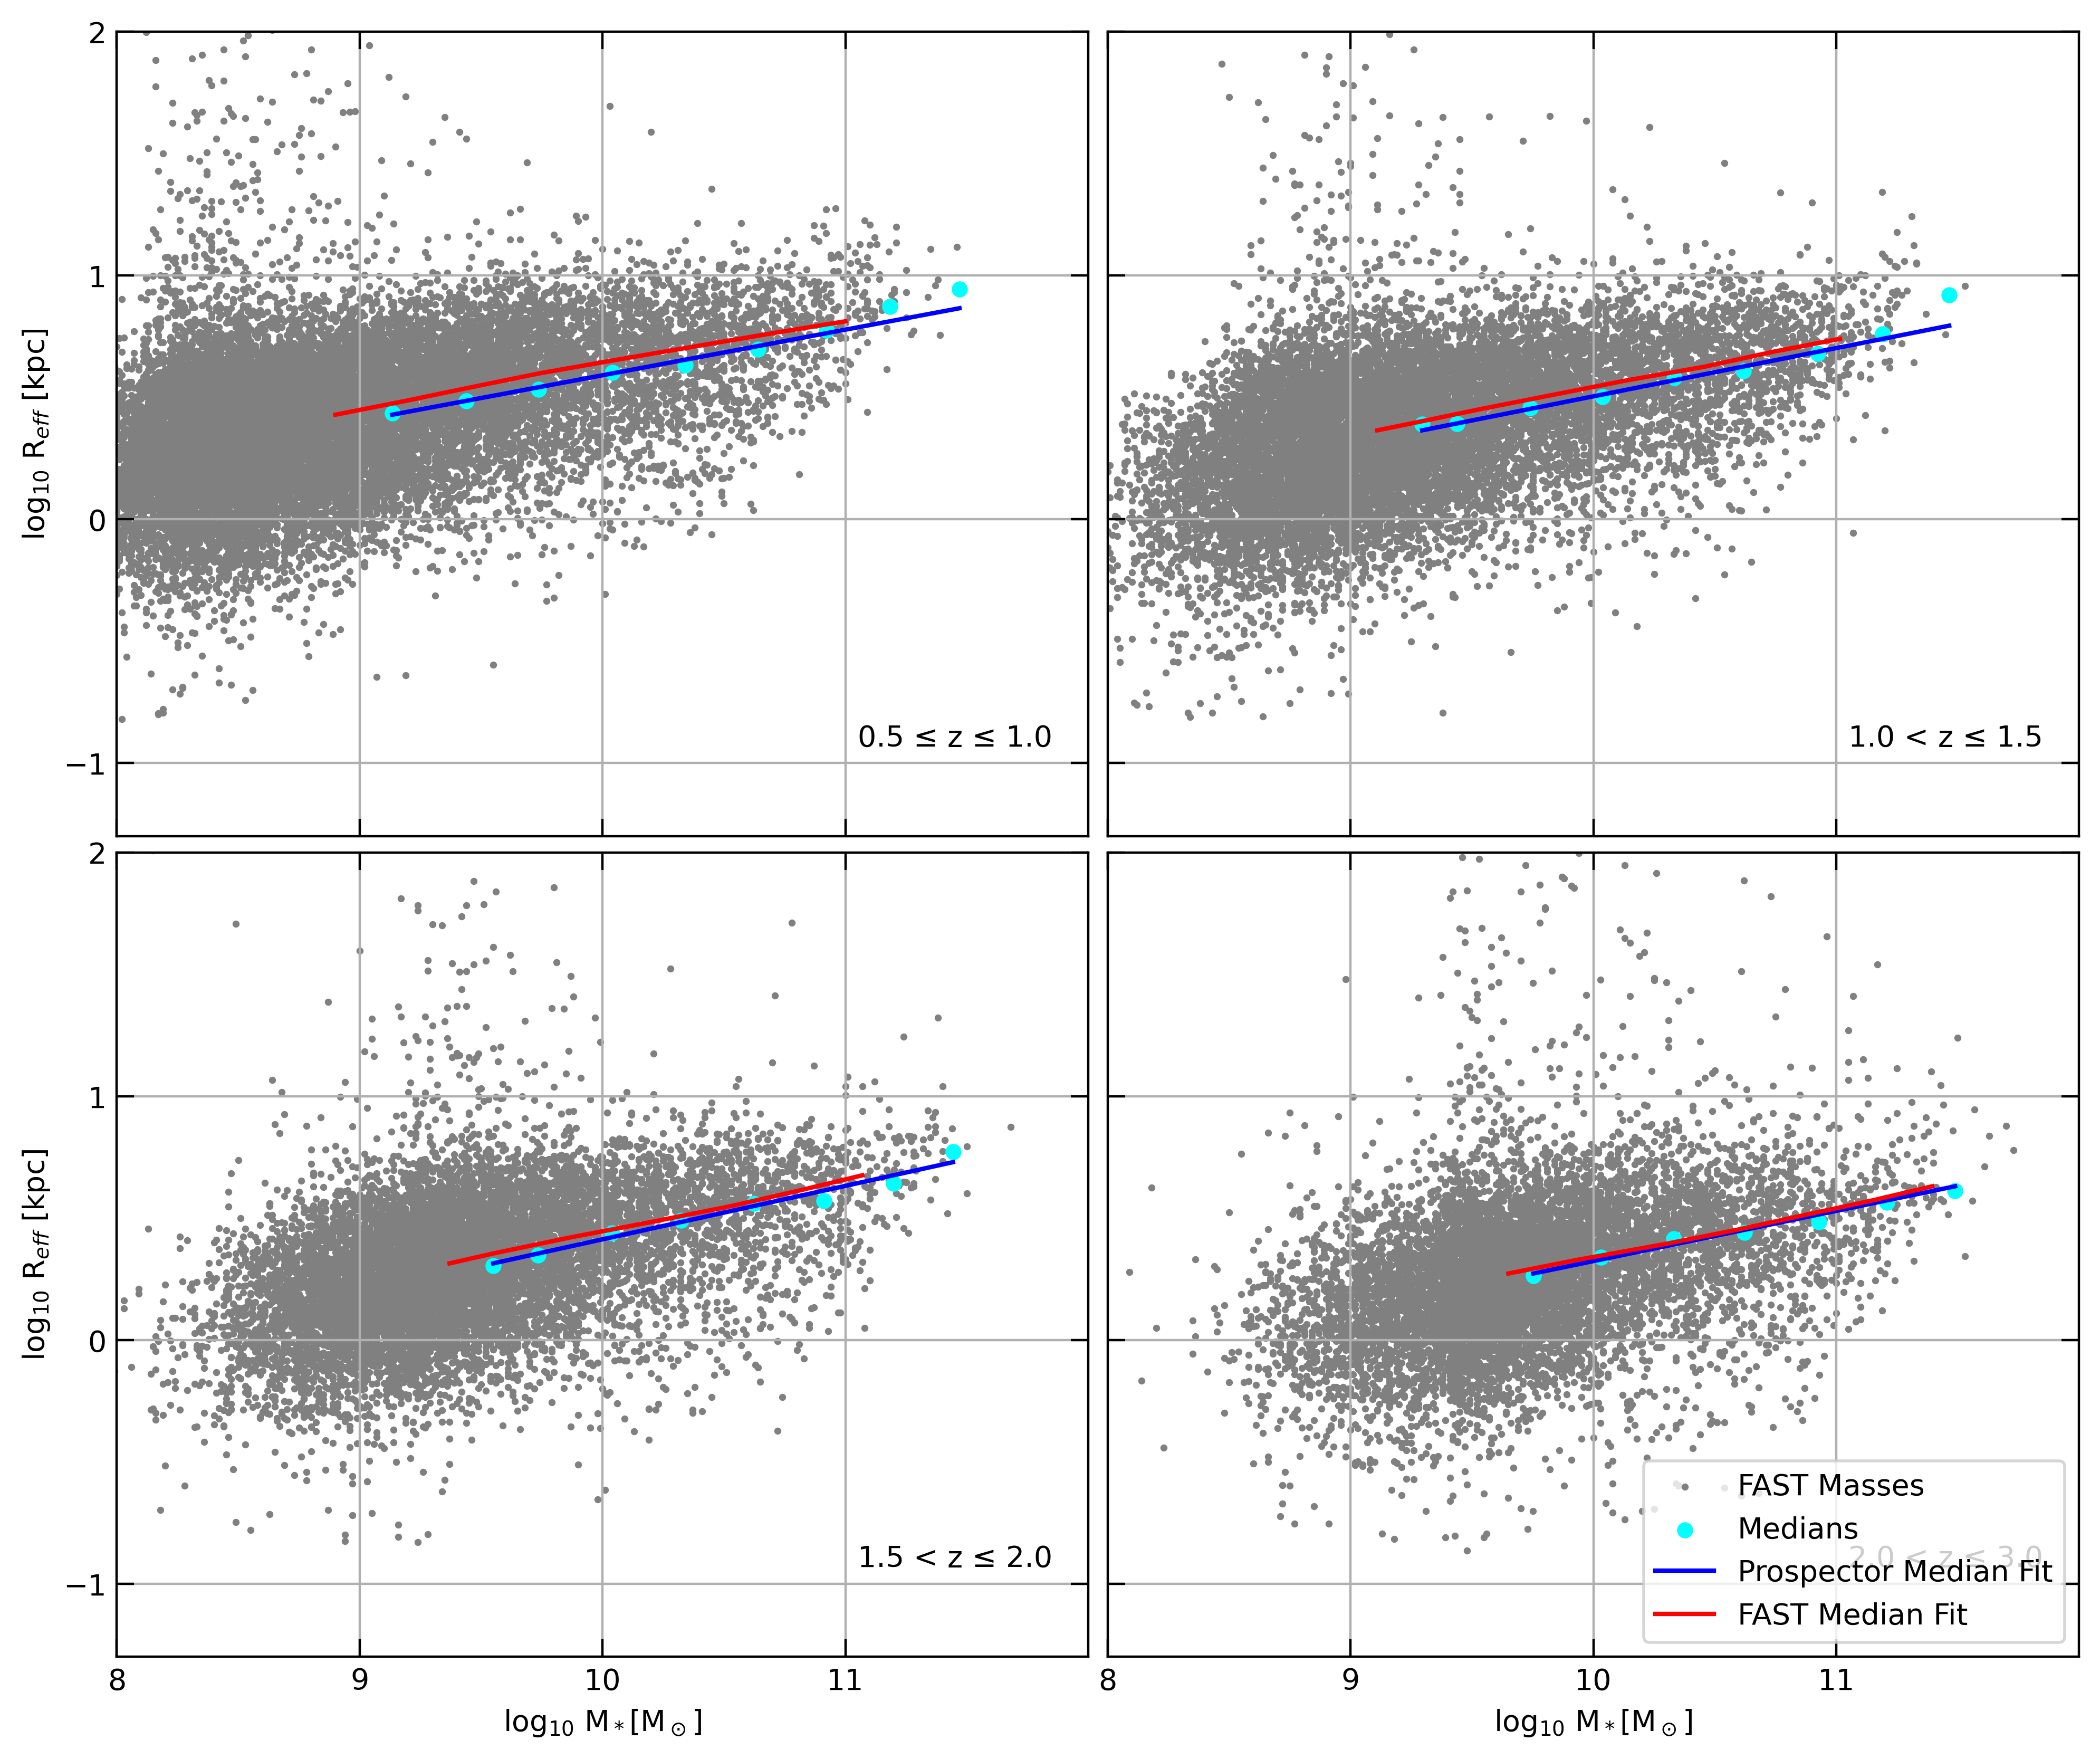

In [19]:
def power_law(M,A,a):
    return A+(a*M-a*np.log10(5e10))

def starforming_fit(xvals, yvals, error):   #curve fit calculation with upper fit and lower fit and comparison line
    fit_sf.append(curve_fit(f=power_law, xdata=xvals, ydata=yvals, sigma=error, p0=x0, bounds=bounds))
    highfit_sf.append(fit_sf[z][0]+np.sqrt(np.diag(fit_sf[z][1])))
    lowfit_sf.append(fit_sf[z][0]-np.sqrt(np.diag(fit_sf[z][1])))
    R_sf_fit.append(power_law(xvals,*fit_sf[z][0]))
    R_sf_low.append(power_law(xvals,*lowfit_sf[z]))
    R_sf_high.append(power_law(xvals,*highfit_sf[z]))

def sort_index(xvals, yvals):  #index sorting function so that mass and radius values correctly correspond to eachother
    sort = sorted(zip(xvals,yvals), key = operator.itemgetter(0))
    zipX,zipY = (zip(*sort))
    return zipX,zipY


#median calculation based on binsize and selection threshold
marray=np.arange(7.5,13,0.3)
M_medians = []
R_medians = []
R_medians_err = []
FAST_medians = []
FASTR_medians = []
FASTR_medians_err = []

for z in range(4):
    mass_med = []
    radius_med = []
    radius_med_err = []
    FAST_med = []
    FASTr_med = []
    FASTr_med_err = []
    for m in marray:
        sel=(starforming_50[z]['lmass']>m)&(starforming_50[z]['lmass']<m+0.3)    #mass selection
        FAST_sel=(starforming_50[z]['FAST_lmass']>m)&(starforming_50[z]['FAST_lmass']<m+0.3)    #mass selection
        if sum(sel)>=10:
            mass_med.append(np.median(starforming_50[z]['lmass'][sel]))  #adding mass medians for each selection
            radius_med.append(np.median(starforming_50[z]['lR_eff'][sel]))   #adding radius medians for each selection
            radius_med_err.append(stats.stdev(starforming_50[z]['lR_eff'][sel])/np.sqrt(len(starforming_50[z]['lR_eff'][sel])))
        if sum(FAST_sel)>=10:
            FAST_med.append(np.median(starforming_50[z]['FAST_lmass'][sel]))  #adding mass medians for each selection
            FASTr_med.append(np.median(starforming_50[z]['lR_eff'][sel]))   #adding radius medians for each selection
            FASTr_med_err.append(stats.stdev(starforming_50[z]['lR_eff'][FAST_sel])/np.sqrt(len(starforming_50[z]['lR_eff'][FAST_sel])))
    mass_med = [i for i in mass_med if np.isnan(i) == False]  #removing nan values from median array
    mass_med = np.asarray(mass_med,dtype=object)
    radius_med = [i for i in radius_med if np.isnan(i) == False]  #removing nan values from median array
    radius_med = np.asarray(radius_med,dtype=object)
    radius_med_err = [i for i in radius_med_err if np.isnan(i) == False]  #removing nan values from median array
    radius_med_err = np.asarray(radius_med_err,dtype=object)
    FAST_med = [i for i in FAST_med if np.isnan(i) == False]  #removing nan values from median array
    FAST_med = np.asarray(FAST_med,dtype=object)
    FASTr_med = [i for i in FASTr_med if np.isnan(i) == False]  #removing nan values from median array
    FASTr_med = np.asarray(FASTr_med,dtype=object)
    FASTr_med_err = [i for i in FASTr_med_err if np.isnan(i) == False]  #removing nan values from median array
    FASTr_med_err = np.asarray(FASTr_med_err,dtype=object)
    M_medians.append(mass_med)
    R_medians.append(radius_med)
    R_medians_err.append(radius_med_err)
    FAST_medians.append(FAST_med)
    FASTR_medians.append(FASTr_med)
    FASTR_medians_err.append(FASTr_med_err)
M_medians = np.asarray(M_medians,dtype=object)
R_medians = np.asarray(R_medians,dtype=object)
R_medians_err = np.asarray(R_medians_err,dtype=object)
M_medians = [a.astype(np.float64) for a in M_medians]
R_medians = [a.astype(np.float64) for a in R_medians]
R_medians_err = [a.astype(np.float64) for a in R_medians_err]
FAST_medians = np.asarray(FAST_medians,dtype=object)
FASTR_medians = np.asarray(FASTR_medians,dtype=object)
FASTR_medians_err = np.asarray(FASTR_medians_err,dtype=object)
FAST_medians = [a.astype(np.float64) for a in FAST_medians]
FASTR_medians = [a.astype(np.float64) for a in FASTR_medians]
FASTR_medians_err = [a.astype(np.float64) for a in FASTR_medians_err]

complete80_q = [9.39,9.83,10.12,10.67]
complete80_sf = [9.22,9.38,9.82,10.09]


x0 =[0.3,0.75] #inital values of fit
bounds = ([-10,-10],[10,10]) #bounds of fit
x0_broken =[1.5,0.01,0.47,10.43] #inital values of fit
bounds_broken = ([-10,-10,-10,9],[10,10,10,12]) #bounds of fit


#arrays in which the outputs of the fitting code will be sent
fit_sf = []
highfit_sf = []
lowfit_sf = []
R_sf_fit = []
R_sf_low = []
R_sf_high = []

prospector_sf_fit = [[],[],[],[]]
prospector_sf_fit_low = [[],[],[],[]]
prospector_sf_fit_high = [[],[],[],[]]
FAST_sf_fit = [[],[],[],[]]
FAST_sf_fit_low = [[],[],[],[]]
FAST_sf_fit_high = [[],[],[],[]]

srtd_lmass_sf = []
srtd_FAST_lmass_sf = []

#fitting data
for z in range(4):
    starforming_fit(M_medians[z], R_medians[z], R_medians_err[z])
    lmass, prospector_sf_fit[z] = sort_index(M_medians[z], R_sf_fit[z])
    srtd_lmass_sf.append(lmass)
    _, prospector_sf_fit_low[z] = sort_index(M_medians[z], R_sf_low[z])
    _, prospector_sf_fit_high[z] = sort_index(M_medians[z], R_sf_high[z])
for z in range(4):
    starforming_fit(FAST_medians[z], FASTR_medians[z], None)
    FAST_lmass, FAST_sf_fit[z] = sort_index(FAST_medians[z], R_sf_fit[z])
    srtd_FAST_lmass_sf.append(FAST_lmass)
    _, FAST_sf_fit_low[z] = sort_index(FAST_medians[z], R_sf_low[z])
    _, FAST_sf_fit_high[z] = sort_index(FAST_medians[z], R_sf_high[z])

    
#plotting data
x = [0,0,1,1]
y = [0,1,0,1]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

for z in range(4):
    ax[x[z],y[z]].scatter(starforming[z]['FAST_lmass'],starforming[z]['lR_eff'],s=2,c='grey',label='FAST Masses')
    ax[x[z],y[z]].scatter(M_medians[z],R_medians[z],s=20,c='cyan', label='Medians')
    ax[x[z],y[z]].plot(srtd_lmass_sf[z],prospector_sf_fit[z],c='blue',label='Prospector Median Fit')
    ax[x[z],y[z]].plot(srtd_FAST_lmass_sf[z],FAST_sf_fit[z],c='red',label='FAST Median Fit')
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=6)
    ax[x[z],y[z]].tick_params(which='minor', direction='in')
    if z == 0 or z == 2:
        ax[x[z],y[z]].set_yticks([-1,0,1,2])
    else:
        ax[x[z],y[z]].set_xticks([8,9,10,11])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    ax[x[z],y[z]].set_xlim(8,12)
    ax[x[z],y[z]].set_ylim(-1.3,2)
    ax[x[z],y[z]].text(11.05,-0.93,zlabels[z])
    if z==2 or z==3:
        ax[x[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
    if z==0 or z==2:
        ax[x[z],y[z]].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
    ax[x[z],y[z]].grid(True,'minor',alpha=0.1)
    ax[x[z],y[z]].grid()
    if z == 3:
        ax[x[z],y[z]].legend()

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

In [21]:
marray=np.arange(7.5,13,0.2)
rarray=np.arange(-1,3,0.2)
M_medians_q = []
R_medians_q = []
FAST_medians_q = []


for z in range(4):
    mass_med = []
    fast_med = []
    radius_med = []
    for m in marray:
        for r in rarray:
            sel=(quiescent[z]['FAST_lmass']>=m)&(quiescent[z]['FAST_lmass']<m+0.2)&(quiescent[z]['lR_eff']>=r)&(quiescent[z]['lR_eff']<r+0.2)
            if sum(sel)>=10:
                box_masses = quiescent[z]['lmass'][sel]
                box_fast = quiescent[z]['FAST_lmass'][sel]
                box_radii = quiescent[z]['lR_eff'][sel]+np.random.normal(scale=0.03)
                mass_med.append(np.median(box_masses))
                fast_med.append(np.median(box_fast))
                radius_med.append(np.median(box_radii))
    mass_med = [i for i in mass_med if np.isnan(i) == False]
    mass_med = np.asarray(mass_med,dtype=object)
    fast_med = [i for i in fast_med if np.isnan(i) == False]
    fast_med = np.asarray(fast_med,dtype=object)
    radius_med = [i for i in radius_med if np.isnan(i) == False]
    radius_med = np.asarray(radius_med,dtype=object)
    M_medians_q.append(mass_med)
    FAST_medians_q.append(fast_med)
    R_medians_q.append(radius_med)

Med_Delta_q = np.array(M_medians_q,dtype=object)-np.array(FAST_medians_q,dtype=object)
RMed_Delta_q = np.array(R_medians_q,dtype=object)-np.array(R_medians_q,dtype=object)
Med_Delta_q = [a.astype(np.float64) for a in Med_Delta_q]
RMed_Delta_q = [a.astype(np.float64) for a in RMed_Delta_q]
FAST_medians_q = [a.astype(np.float64) for a in FAST_medians_q]
R_medians_q = [a.astype(np.float64) for a in R_medians_q]
M_medians_q = [a.astype(np.float64) for a in M_medians_q]
         
carray=np.arange(8.5,13,0.25)
mass_q = [[],[],[],[]]
frac_q = [[],[],[],[]]
for i in range(4):
    for c in marray:
        sel=(quiescent[i]['lmass']>c)&(quiescent[i]['lmass']<c+0.25)
        if sum(sel)!= 0:
            mass_q[i].append(c+0.25)
            frac_q[i].append(len(quiescent[i]['lmass'][(sel)&(quiescent[i]['mag_f160w']<24.5)])/len(quiescent[i]['lmass'][sel]))

In [22]:
marray=np.arange(7.5,13,0.2)
rarray=np.arange(-1,3,0.2)
M_medians_sf = []
R_medians_sf = []
FAST_medians_sf = []


for z in range(4):
    mass_med = []
    fast_med = []
    radius_med = []
    for m in marray:
        for r in rarray:
            sel=(starforming[z]['FAST_lmass']>=m)&(starforming[z]['FAST_lmass']<m+0.2)&(starforming[z]['lR_eff']>=r)&(starforming[z]['lR_eff']<r+0.2)
            if sum(sel)>=10:
                box_masses = starforming[z]['lmass'][sel]
                box_fast = starforming[z]['FAST_lmass'][sel]
                box_radii = starforming[z]['lR_eff'][sel]+np.random.normal(scale=0.03)
                mass_med.append(np.median(box_masses))
                fast_med.append(np.median(box_fast))
                radius_med.append(np.median(box_radii))
    mass_med = [i for i in mass_med if np.isnan(i) == False]
    mass_med = np.asarray(mass_med,dtype=object)
    fast_med = [i for i in fast_med if np.isnan(i) == False]
    fast_med = np.asarray(fast_med,dtype=object)
    radius_med = [i for i in radius_med if np.isnan(i) == False]
    radius_med = np.asarray(radius_med,dtype=object)
    M_medians_sf.append(mass_med)
    FAST_medians_sf.append(fast_med)
    R_medians_sf.append(radius_med)

Med_Delta_sf = np.array(M_medians_sf,dtype=object)-np.array(FAST_medians_sf,dtype=object)
RMed_Delta_sf = np.array(R_medians_sf,dtype=object)-np.array(R_medians_sf,dtype=object)
Med_Delta_sf = [a.astype(np.float64) for a in Med_Delta_sf]
RMed_Delta_sf = [a.astype(np.float64) for a in RMed_Delta_sf]
FAST_medians_sf = [a.astype(np.float64) for a in FAST_medians_sf]
R_medians_sf = [a.astype(np.float64) for a in R_medians_sf]
M_medians_sf = [a.astype(np.float64) for a in M_medians_sf]
         
carray=np.arange(8.5,13,0.25)
mass_sf = [[],[],[],[]]
frac_sf = [[],[],[],[]]
for i in range(4):
    for c in marray:
        sel=(starforming[i]['lmass']>c)&(starforming[i]['lmass']<c+0.25)
        if sum(sel)!= 0:
            mass_sf[i].append(c+0.25)
            frac_sf[i].append(len(starforming[i]['lmass'][(sel)&(starforming[i]['mag_f160w']<24.5)])/len(starforming[i]['lmass'][sel]))

/var/folders/cf/h_nh_x353h98db_r9nwq4sqm0000gn/T/ipykernel_11067/3485309050.py:74: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=starforming[z]['FAST_lmass'], y=starforming[z]['lR_eff'], shade=True, cmap='binary', ax=ax[x[z],y[z]], alpha=0.65, label='Star-forming FAST Masses')#, levels=levels)
/var/folders/cf/h_nh_x353h98db_r9nwq4sqm0000gn/T/ipykernel_11067/3485309050.py:74: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=starforming[z]['FAST_lmass'], y=starforming[z]['lR_eff'], shade=True, cmap='binary', ax=ax[x[z],y[z]], alpha=0.65, label='Star-forming FAST Masses')#, levels=levels)
/var/folders/cf/h_nh_x353h98db_r9nwq4sqm0000gn/T/ipykernel_11067/3485309050.py:74: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fil

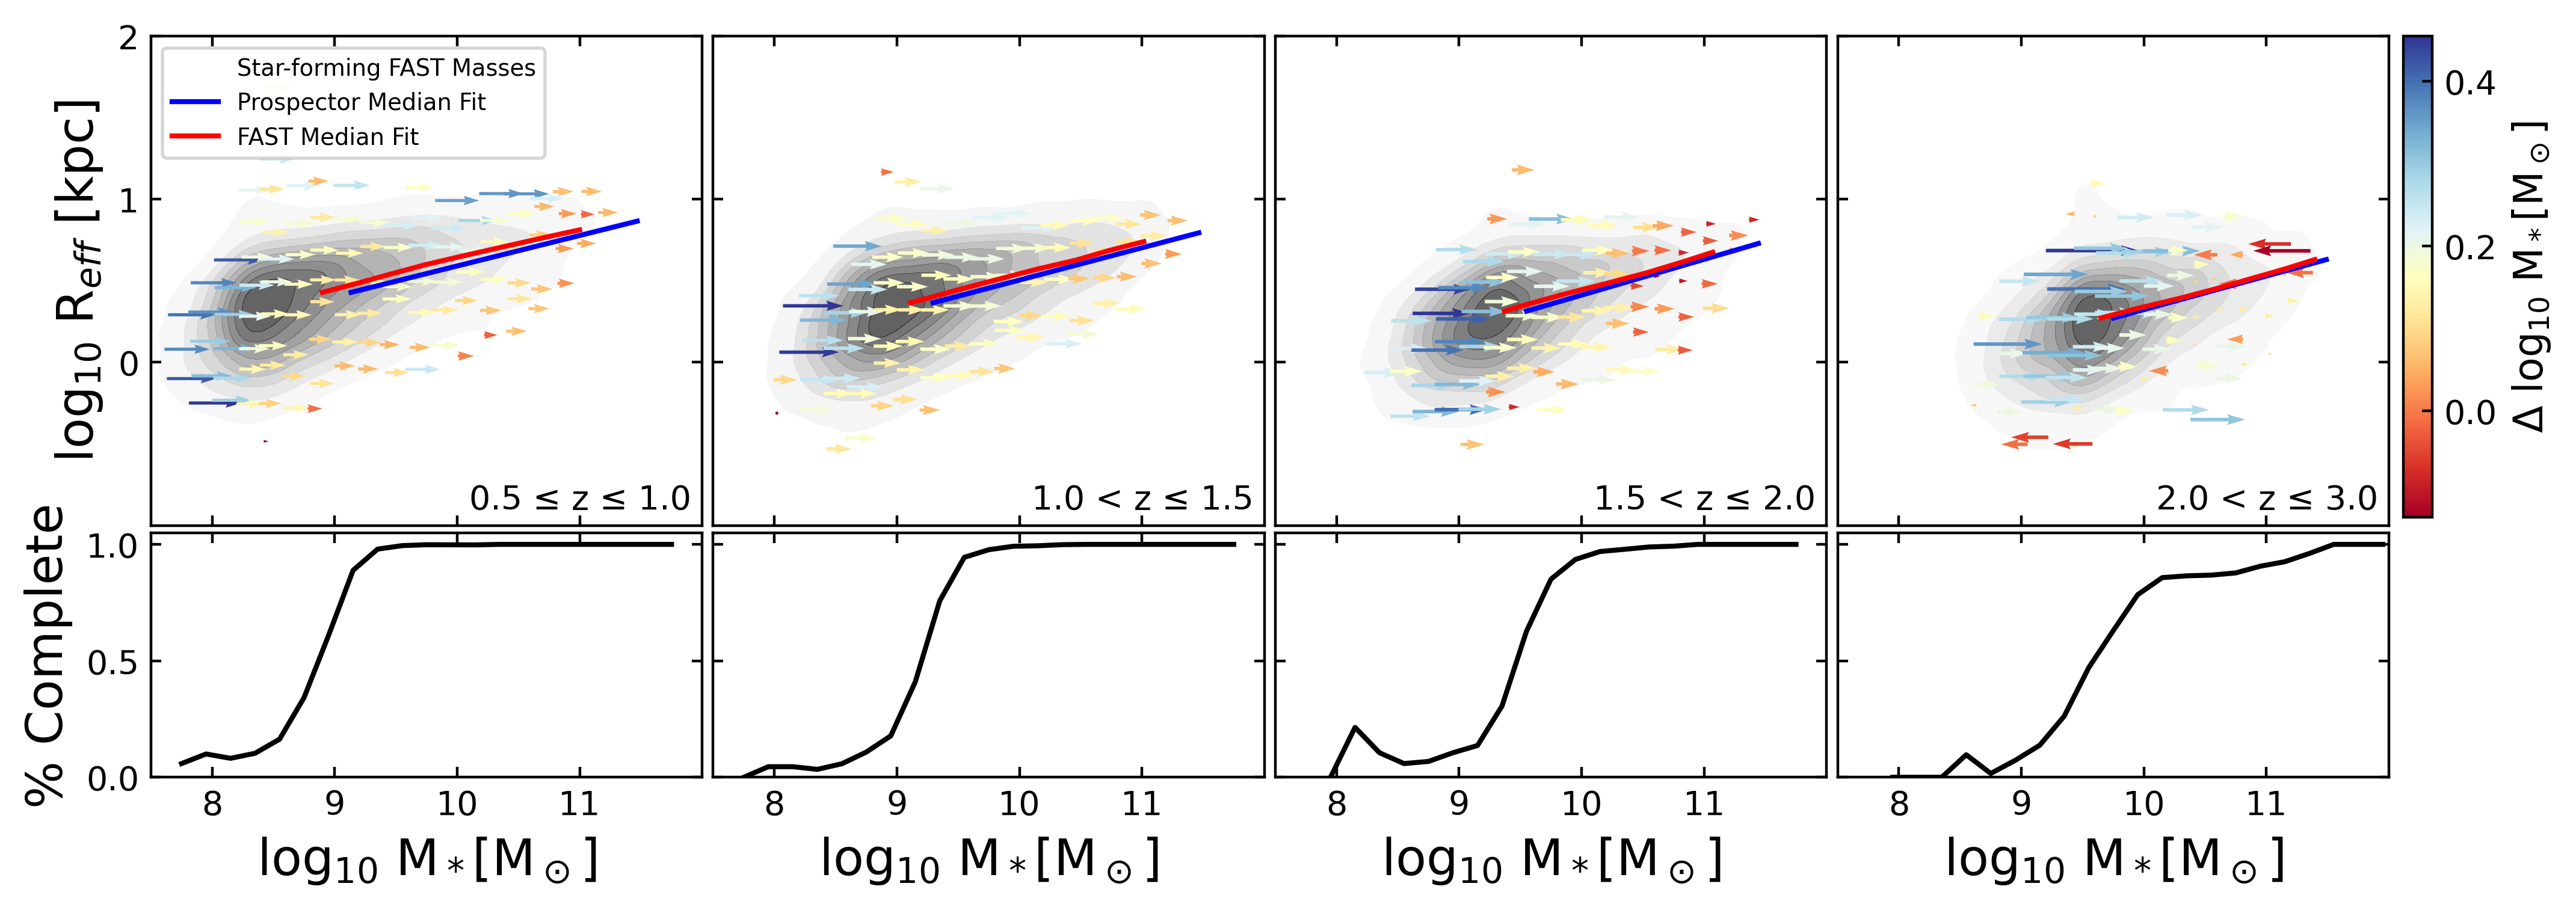

In [23]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    #plt.register_cmap(cmap=newcmap)

    return newcmap

fig, ax = plt.subplots(2, 4, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

x = [0,0,0,0]
x2 = [1,1,1,1]
y = [0,1,2,3]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']


map1 = plt.cm.Reds_r(np.linspace(0., 1, 128))
map2 = plt.get_cmap(name='cma:laguna_r')(np.linspace(0, 1, 128))

# combine them and build a new colormap
comb_map = np.vstack((map1, map2))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', comb_map)
cmap = shiftedColorMap(mymap, midpoint=0.24)
cmap = plt.cm.RdYlBu
cNorm  = colors.Normalize(vmin=min(min(x) for x in Med_Delta_sf), vmax=max(max(x) for x in Med_Delta_sf))
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

levels=[.1,.2,.3,.4,.6,.7,.8,.9,1]

for z in range(4):
    sns.kdeplot(x=starforming[z]['FAST_lmass'], y=starforming[z]['lR_eff'], shade=True, cmap='binary', ax=ax[x[z],y[z]], alpha=0.65, label='Star-forming FAST Masses')#, levels=levels)
    ax[x[z],y[z]].plot(srtd_lmass_sf[z],prospector_sf_fit[z],c='blue',label='Prospector Median Fit')
    ax[x[z],y[z]].plot(srtd_FAST_lmass_sf[z],FAST_sf_fit[z],c='red',label='FAST Median Fit')
    ax[x[z],y[z]].quiver(FAST_medians_sf[z], R_medians_sf[z], Med_Delta_sf[z], RMed_Delta_sf[z], Med_Delta_sf[z], cmap=cmap)
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=3)
    ax[x[z],y[z]].tick_params(which='minor', direction='in', length=1)
    ax[x[z],y[z]].set_yticks([0,1,2])
    ax[x[z],y[z]].set_xticks([8,9,10,11])
    if z > 0:
        ax[x[z],y[z]].set_yticklabels([])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    ax[x[z],y[z]].set_xlim(7.5,12)
    ax[x[z],y[z]].set_ylim(-1,2)
    #ax[x[z],y[z]].set_yscale('log')
    ax[x[z],y[z]].text(10.1,-0.9,zlabels[z])
    if z==0:
        ax[x[z],y[z]].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]', fontsize=15)
    else:
        ax[x[z],y[z]].set_ylabel('')
    if z == 0:
        ax[x[z],y[z]].legend(fontsize='x-small', loc='upper left')

for z in range(4):
    ax[x2[z],y[z]].plot(mass_sf[z],frac_sf[z],c='black')
    ax[x2[z],y[z]].set_ylim(0,1.05)
    if z > 0:
        ax[x2[z],y[z]].set_yticklabels([])
    ax[x2[z],y[z]].tick_params(which='major', direction='in', length=3)
    ax[x2[z],y[z]].tick_params(which='minor', direction='in')
    ax[x2[z],y[z]].xaxis.set_ticks_position('both')
    ax[x2[z],y[z]].yaxis.set_ticks_position('both')
    ax[x2[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]', fontsize=15)
    if z==0:
        ax[x2[z],y[z]].set_ylabel('% Complete', fontsize=15)
    ax[x2[z],y[z]].grid(True,'minor',alpha=0.1)
    
    
cbar_ax = fig.add_axes([0.905, 0.380, 0.010, 0.500])

cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=cNorm, orientation='vertical', ticks=[0, 0.2, 0.4])
cb.ax.set_ylabel('$\Delta$ log$_{10}$ M$_*$[M$_\odot$]', fontsize=12)
cb.ax.tick_params(direction='in', length=3)

plt.gcf().set_size_inches(12, 4)
plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

/var/folders/cf/h_nh_x353h98db_r9nwq4sqm0000gn/T/ipykernel_11067/1145634526.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=quiescent[z]['FAST_lmass'], y=quiescent[z]['lR_eff'], shade=True, cmap='binary', ax=ax[x[z],y[z]], alpha=0.65,label='Quiescent FAST Masses')#, levels=levels)
/var/folders/cf/h_nh_x353h98db_r9nwq4sqm0000gn/T/ipykernel_11067/1145634526.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=quiescent[z]['FAST_lmass'], y=quiescent[z]['lR_eff'], shade=True, cmap='binary', ax=ax[x[z],y[z]], alpha=0.65,label='Quiescent FAST Masses')#, levels=levels)
/var/folders/cf/h_nh_x353h98db_r9nwq4sqm0000gn/T/ipykernel_11067/1145634526.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This wi

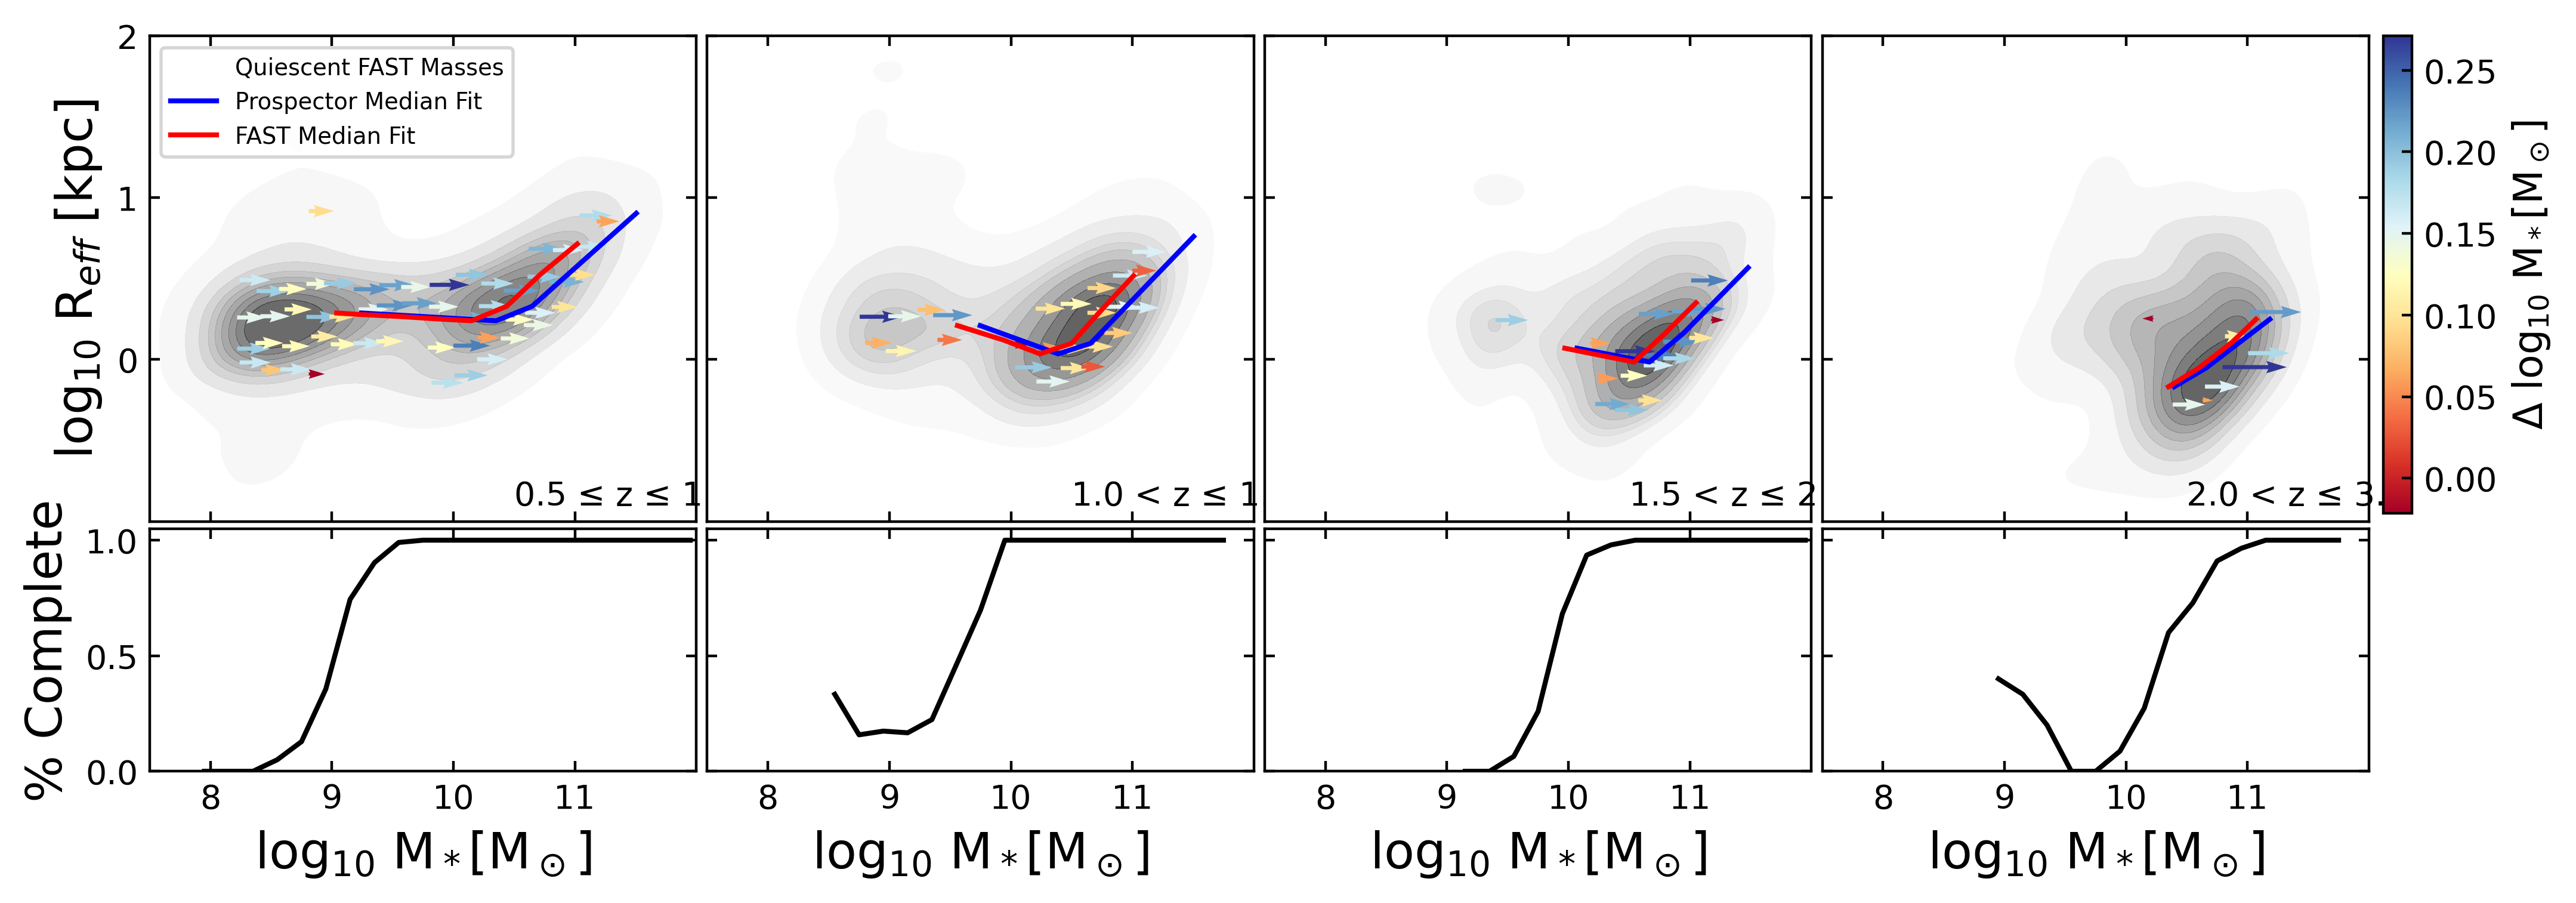

In [24]:
fig, ax = plt.subplots(2, 4, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

x = [0,0,0,0]
x2 = [1,1,1,1]
y = [0,1,2,3]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']


map1 = plt.cm.Reds_r(np.linspace(0., 1, 128))
map2 = plt.get_cmap(name='cma:laguna_r')(np.linspace(0, 1, 128))

# combine them and build a new colormap
comb_map = np.vstack((map1, map2))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', comb_map)
#cmap = shiftedColorMap(mymap, midpoint=0.22)
cmap = plt.cm.RdYlBu
cNorm  = colors.Normalize(vmin=min(min(x) for x in Med_Delta_q), vmax=max(max(x) for x in Med_Delta_q))
#cNorm  = colors.Normalize(vmin=min(min(x) for x in Med_Delta_sf), vmax=max(max(x) for x in Med_Delta_sf))

scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

levels=[.1,.2,.3,.4,.6,.7,.8,.9,1]

for z in range(4):
    sns.kdeplot(x=quiescent[z]['FAST_lmass'], y=quiescent[z]['lR_eff'], shade=True, cmap='binary', ax=ax[x[z],y[z]], alpha=0.65,label='Quiescent FAST Masses')#, levels=levels)
    ax[x[z],y[z]].plot(srtd_lmass_q[z],prospector_q_fit[z],c='blue',label='Prospector Median Fit')
    ax[x[z],y[z]].plot(srtd_FAST_lmass_q[z],FAST_q_fit[z],c='red',label='FAST Median Fit')
    ax[x[z],y[z]].quiver(FAST_medians_q[z], R_medians_q[z], Med_Delta_q[z], RMed_Delta_q[z], Med_Delta_q[z], cmap=cmap)
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=3)
    ax[x[z],y[z]].tick_params(which='minor', direction='in', length=1)
    ax[x[z],y[z]].set_yticks([0,1,2])
    ax[x[z],y[z]].set_xticks([8,9,10,11])
    if z > 0:
        ax[x[z],y[z]].set_yticklabels([])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    ax[x[z],y[z]].set_xlim(7.5,12)
    ax[x[z],y[z]].set_ylim(-1,2)
    #ax[x[z],y[z]].set_yscale('log')
    ax[x[z],y[z]].text(10.5,-0.9,zlabels[z])
    if z==0:
        ax[x[z],y[z]].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]', fontsize=15)
    else:
        ax[x[z],y[z]].set_ylabel('')
    ax[x[z],y[z]].grid(True,'minor',alpha=0.5)
    #ax[x[z],y[z]].grid()
    if z == 0:
        ax[x[z],y[z]].legend(fontsize='x-small', loc='upper left')

for z in range(4):
    ax[x2[z],y[z]].plot(mass_q[z],frac_q[z],c='black')
    ax[x2[z],y[z]].set_ylim(0,1.05)
    if z > 0:
        ax[x2[z],y[z]].set_yticklabels([])
    ax[x2[z],y[z]].tick_params(which='major', direction='in', length=3)
    ax[x2[z],y[z]].tick_params(which='minor', direction='in')
    ax[x2[z],y[z]].xaxis.set_ticks_position('both')
    ax[x2[z],y[z]].yaxis.set_ticks_position('both')
    ax[x2[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]', fontsize=15)
    if z==0:
        ax[x2[z],y[z]].set_ylabel('% Complete', fontsize=15)
    ax[x2[z],y[z]].grid(True,'minor',alpha=0.1)
    
    
cbar_ax = fig.add_axes([0.905, 0.380, 0.010, 0.500])

cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=cNorm, orientation='vertical')#, ticks=[0, 0.2, 0.4])
cb1.ax.set_ylabel('$\Delta$ log$_{10}$ M$_*$[M$_\odot$]', fontsize=12)
cb1.ax.tick_params(direction='in', length=3)

plt.gcf().set_size_inches(12, 4)
plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()